<a href="https://colab.research.google.com/github/rgmerski/ObjectCountingCNN/blob/main/Notebooks/Own_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Wstęp

Aby nie zniszczyć przypadkowo (jak i żeby umożliwiśc uruchomienie pełnego notatnika dotyczącego tego zagadnienia) wyników otrzymanych z nauczania sieci na podstawie ResNet50v2 stworzyłem ten notatnik. W nim stworzę swój własny model i będę go testował. Na pewno pozwoli mi to na większe możliwości dostosowania jak i testowania. Jednak sieć ResNet50v2 jest wciąż spora patrząc na mój problem.

In [ ]:
%tensorflow_version 2.x
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
tf.__version__

'2.5.0'

In [ ]:
! python3 --version

Python 3.7.10


**GPU:**

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


**Połączenie z dyskiem**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Wczytanie danych i utworzenie datasetów**

In [ ]:
image_size = (224, 224)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/dataset",
    labels="inferred",
    validation_split=0.2,
    subset="training",
    seed=55,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/dataset",
    labels="inferred",
    validation_split=0.2,
    subset="validation",
    seed=55,
    image_size=image_size,
    batch_size=batch_size,
)

classes = [1, 2, 3, 4, 5, 6]
n_cls = len(classes)

Found 4718 files belonging to 6 classes.
Using 3775 files for training.
Found 4718 files belonging to 6 classes.
Using 943 files for validation.


**Przykładowe dane treningowe**

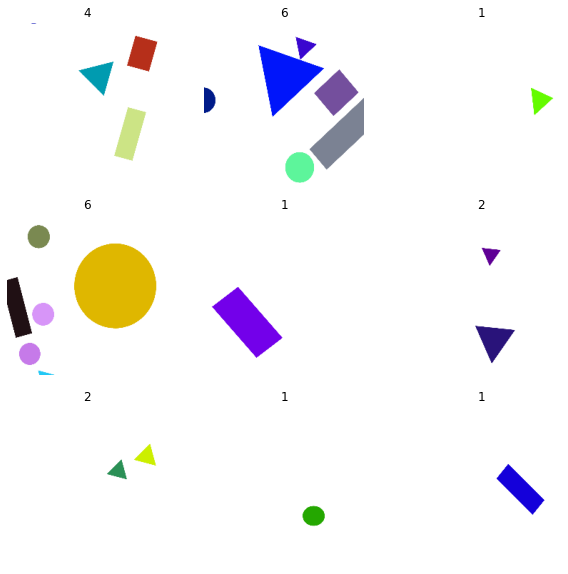

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

#2. Tworzenie modeli

In [ ]:
def my_model(l_r, op = 'Adam'):

  model = Sequential()

  model.add(Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)))
  model.add(Conv2D(32, (3,3), activation='relu'))
  model.add(MaxPooling2D(2,2))
  model.add(Dropout(0.4))

  model.add(Conv2D(64, (3,3), activation='relu'))
  model.add(Conv2D(64, (3,3), activation='relu'))
  model.add(MaxPooling2D(2,2))
  model.add(Dropout(0.4))

  model.add(Flatten())

  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_cls, activation='softmax'))

  #model.summary()
  if op!='Adam':
    opt = keras.optimizers.SGD(learning_rate=l_r)
  else:
    opt = keras.optimizers.Adam(learning_rate=l_r)

  model.compile(optimizer=opt ,loss='SparseCategoricalCrossentropy',metrics=['accuracy'])

  return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 64)        0

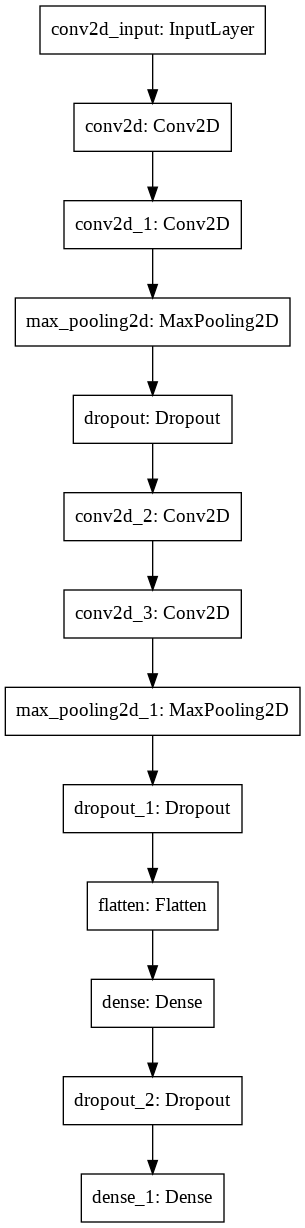

In [ ]:
keras.backend.clear_session() 
from keras.utils.vis_utils import plot_model
model_temp = my_model(0.005)
plot_model(model_temp)

In [ ]:
def my_modelSGD(l_r):

  model = Sequential()

  model.add(Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)))
  model.add(Conv2D(32, (3,3), activation='relu'))
  model.add(MaxPooling2D(2,2))
  model.add(Dropout(0.4))

  model.add(Conv2D(64, (3,3), activation='relu'))
  model.add(Conv2D(64, (3,3), activation='relu'))
  model.add(MaxPooling2D(2,2))
  model.add(Dropout(0.4))

  model.add(Flatten())

  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_cls, activation='softmax'))

  #model.summary()

  opt = keras.optimizers.Adam(learning_rate=l_r)
  sgd = keras.optimizers.SGD(learning_rate=l_r)
  #model.compile(optimizer=opt ,loss='SparseCategoricalCrossentropy',metrics=['accuracy'])
  model.compile(optimizer=sgd ,loss='SparseCategoricalCrossentropy',metrics=['accuracy'])

  return model

#3. Trenowanie modeli

##Porównywanie modeli

In [ ]:
def multi_graph(models, rates, name ="", sizeX = 20.0, sizeY = 15.0):
    
    plt.rcParams['figure.figsize'] = (sizeX, sizeY) # Setting default size of plots
    plt.suptitle(name)
    plt.subplot(2,2,1)
    #print(len(models))
    for i in range(len(models)):
        plt.plot(models[i].history['accuracy'], '-o', linewidth=3.0, label='{0:.4f}a'.format(rates[i]))
    plt.legend(loc=4)
    plt.xlabel('Epoch', fontsize=20)
    plt.ylabel('Accuracy', fontsize=20)
    plt.tick_params(labelsize=18)
        
    plt.subplot(2,2,2)
    for i in range(len(models)):
        plt.plot(models[i].history['val_accuracy'], '-o', linewidth=3.0, label='{0:.4f}x'.format(rates[i]))
    plt.legend(loc=4)
    plt.xlabel('Epoch', fontsize=20)
    plt.ylabel('Validation accuracy', fontsize=20)
    plt.tick_params(labelsize=18)
    
    plt.subplot(2,2,3)
    for i in range(len(models)):
        plt.plot(models[i].history['val_loss'], '-o', linewidth=3.0, label='{0:.4f}x'.format(rates[i])) 
    plt.legend(loc=4)
    plt.xlabel('Epoch', fontsize=20)
    plt.ylabel('Validation loss', fontsize=20)
    plt.tick_params(labelsize=18)
    
    plt.show()
    plt.close()

## Nauczanie

### Opisanie funkcji uczącej (training) oraz zmiennych

In [ ]:
epochs = 20
batch_size = 32
early_stop = 5

callbacks = [
    keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = early_stop),
    #keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5", monitor = 'val_loss', save_best_only = True, mode = 'auto')
]

In [ ]:
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
    if epoch < 10:
        #print('lr = ',lr)
        return lr
    else:
        #print('lr = ',lr * tf.math.exp(-0.1))
        return lr * tf.math.exp(-0.1)

In [ ]:
def training(model, epochs, batch_size, stop = True, ann = False):
  if stop:
    temp = model.fit(
        train_ds,
        batch_size = batch_size,
        epochs = epochs,
        validation_data = val_ds,
        callbacks=callbacks
    )
  else:
    if ann:
      annealer = LearningRateScheduler(scheduler)
      temp = model.fit(
        train_ds,
        batch_size = batch_size,
        epochs = epochs,
        validation_data = val_ds,
        callbacks = [annealer]
      )
    else:
      temp = model.fit(
          train_ds,
          batch_size = batch_size,
          epochs = epochs,
          validation_data = val_ds
      )
  return temp

### Porównanie optymalizatorów - Adam i SGD

In [ ]:
# Można dodawać
RATES = [0.001, 0.01]
MODELS = []
MODELS_SGD = []
for x in RATES:
  temp = my_model(x)
  temp = training(temp, epochs, batch_size)
  MODELS.append(temp)

  temp_sgd = my_modelSGD(x)
  temp_sgd = training(temp_sgd, epochs, batch_size)
  MODELS_SGD.append(temp_sgd)



Epoch 1/20
236/236 [==============================] - 2186s 9s/step - loss: 348.3844 - accuracy: 0.2363 - val_loss: 1.7121 - val_accuracy: 0.2863
Epoch 2/20
236/236 [==============================] - 91s 379ms/step - loss: 1.6953 - accuracy: 0.3132 - val_loss: 1.7048 - val_accuracy: 0.2874
Epoch 3/20
236/236 [==============================] - 91s 379ms/step - loss: 1.6848 - accuracy: 0.3131 - val_loss: 1.7034 - val_accuracy: 0.2863
Epoch 4/20
236/236 [==============================] - 90s 376ms/step - loss: 1.6832 - accuracy: 0.3160 - val_loss: 1.7036 - val_accuracy: 0.2863
Epoch 5/20
236/236 [==============================] - 92s 383ms/step - loss: 1.6796 - accuracy: 0.3175 - val_loss: 1.7053 - val_accuracy: 0.2874
Epoch 6/20
236/236 [==============================] - 91s 377ms/step - loss: 1.6795 - accuracy: 0.3175 - val_loss: 1.7039 - val_accuracy: 0.2863
Epoch 7/20
236/236 [==============================] - 91s 378ms/step - loss: 1.6762 - accuracy: 0.3159 - val_loss: 1.7086 - val_a

In [ ]:
all_models = []
all_models = MODELS + MODELS_SGD
print(len(all_models))

4


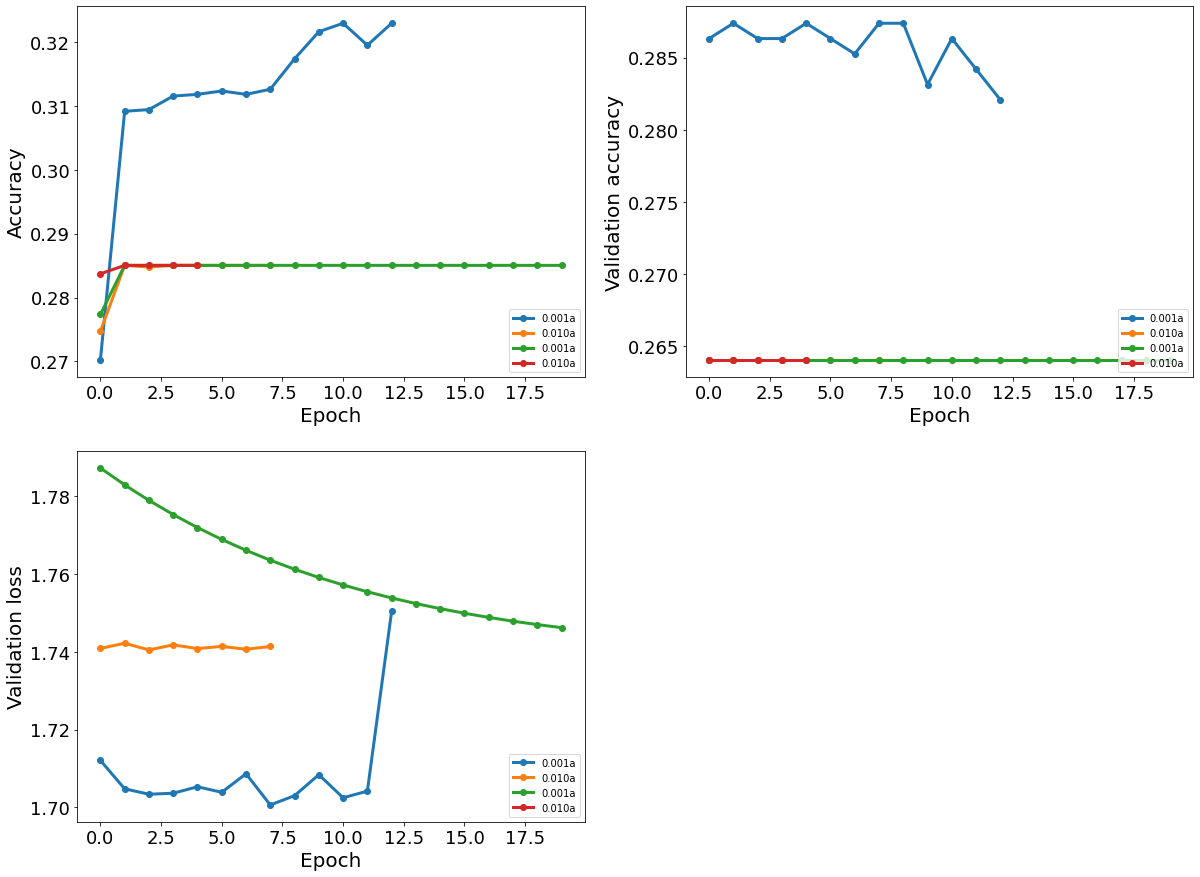

In [ ]:
RATES += RATES
multi_graph(all_models, RATES)

Widać więc, że optymalizator Adam sprawuje się lepiej od SGD, w dodatku dla learning rate = 0.001 mamy zadowalające wyniki. Sprawdzę dla jeszcze mniejszych i będę się skupiał na samym optymalizatorze Adam.

### Testowanie różnych modeli

**Oczywiście w ostatniej warstwie znajduje się 6, gdyż taka jest liczba klas**

#### Porównanie parametrów nauczania

In [ ]:
epochs = 20
RATES = [0.0001, 0.005, 0.001, 0.05]
MODELS = []

In [ ]:
for rate in RATES:
  temp = my_model(rate)
  temp = training(temp, epochs, batch_size)
  MODELS.append(temp)

Epoch 1/20
118/118 [==============================] - 52s 417ms/step - loss: 126.0221 - accuracy: 0.2105 - val_loss: 1.7905 - val_accuracy: 0.2641
Epoch 2/20
118/118 [==============================] - 50s 407ms/step - loss: 1.7897 - accuracy: 0.2940 - val_loss: 1.7885 - val_accuracy: 0.2641
Epoch 3/20
118/118 [==============================] - 50s 406ms/step - loss: 1.7876 - accuracy: 0.2847 - val_loss: 1.7865 - val_accuracy: 0.2641
Epoch 4/20
118/118 [==============================] - 49s 402ms/step - loss: 1.7852 - accuracy: 0.2864 - val_loss: 1.7845 - val_accuracy: 0.2641
Epoch 5/20
118/118 [==============================] - 50s 407ms/step - loss: 1.7829 - accuracy: 0.2882 - val_loss: 1.7825 - val_accuracy: 0.2641
Epoch 6/20
118/118 [==============================] - 50s 404ms/step - loss: 1.7809 - accuracy: 0.2855 - val_loss: 1.7806 - val_accuracy: 0.2641
Epoch 7/20
118/118 [==============================] - 50s 403ms/step - loss: 1.7784 - accuracy: 0.2864 - val_loss: 1.7787 - val_

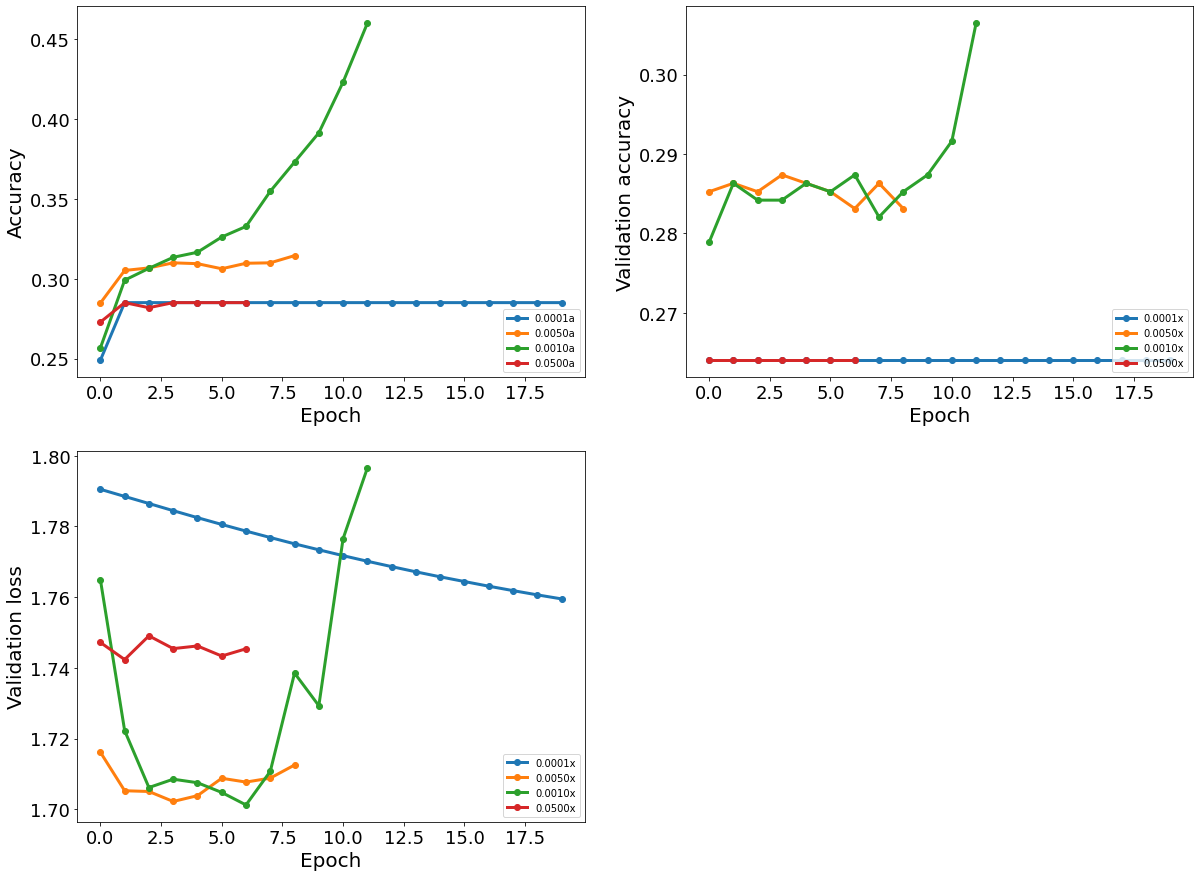

In [ ]:
multi_graph(MODELS, RATES)

#### Porównanie parametrów nauczania - callbacki

Dla alpha = 0.001 najlepsze wyniki, widać też że za szybko się on kończy uczyć przy takich warunkach.
Wyłączę obsługę callback przy treningu, gdyż val_loss się nie zmienia przez kilka epok znacznie, przez co sieć się dalej się nie uczy. A mogłaby przy takich wartościach straty.

In [ ]:
l_r = 0.001
epochs = 20
batch_size = 64
early_stop = 5

In [ ]:
def my_model(l_r):

  model = Sequential()

  model.add(Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)))
  model.add(Conv2D(32, (3,3), activation='relu'))
  model.add(MaxPooling2D(2,2))
  model.add(Dropout(0.4))

  model.add(Conv2D(64, (3,3), activation='relu'))
  model.add(Conv2D(64, (3,3), activation='relu'))
  model.add(MaxPooling2D(2,2))
  model.add(Dropout(0.4))

  model.add(Flatten())

  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_cls, activation='softmax'))

  #model.summary()

  opt = keras.optimizers.Adam(learning_rate=l_r)

  model.compile(optimizer=opt ,loss='SparseCategoricalCrossentropy',metrics=['accuracy'])

  return model

In [ ]:
test_ = []
test0 = my_model(l_r)
test1 = my_model(l_r)
test2 = my_model(l_r)

test_0 = training(test0, epochs, batch_size)
test_.append(test_0)

test_1 = training(test1, epochs, batch_size, False)
test_.append(test_1)

test_2 = training(test2, epochs, batch_size, False, True)
test_.append(test_2)

Epoch 1/20
236/236 [==============================] - 3217s 14s/step - loss: 176.2181 - accuracy: 0.2543 - val_loss: 1.7338 - val_accuracy: 0.2821
Epoch 2/20
236/236 [==============================] - 91s 378ms/step - loss: 1.7082 - accuracy: 0.3074 - val_loss: 1.7033 - val_accuracy: 0.2853
Epoch 3/20
236/236 [==============================] - 90s 376ms/step - loss: 1.6831 - accuracy: 0.3106 - val_loss: 1.7032 - val_accuracy: 0.2842
Epoch 4/20
236/236 [==============================] - 91s 379ms/step - loss: 1.6731 - accuracy: 0.3181 - val_loss: 1.7167 - val_accuracy: 0.2789
Epoch 5/20
236/236 [==============================] - 91s 378ms/step - loss: 1.6570 - accuracy: 0.3267 - val_loss: 1.7562 - val_accuracy: 0.2725
Epoch 6/20
236/236 [==============================] - 90s 376ms/step - loss: 1.6545 - accuracy: 0.3353 - val_loss: 1.7787 - val_accuracy: 0.2704
Epoch 7/20
236/236 [==============================] - 90s 375ms/step - loss: 1.6254 - accuracy: 0.3391 - val_loss: 1.7842 - val_

In [ ]:
l_rs = []
for x in range(len(test_)):
  l_rs.append(l_r)

In [ ]:
print(l_rs)

[0.001, 0.001, 0.001]


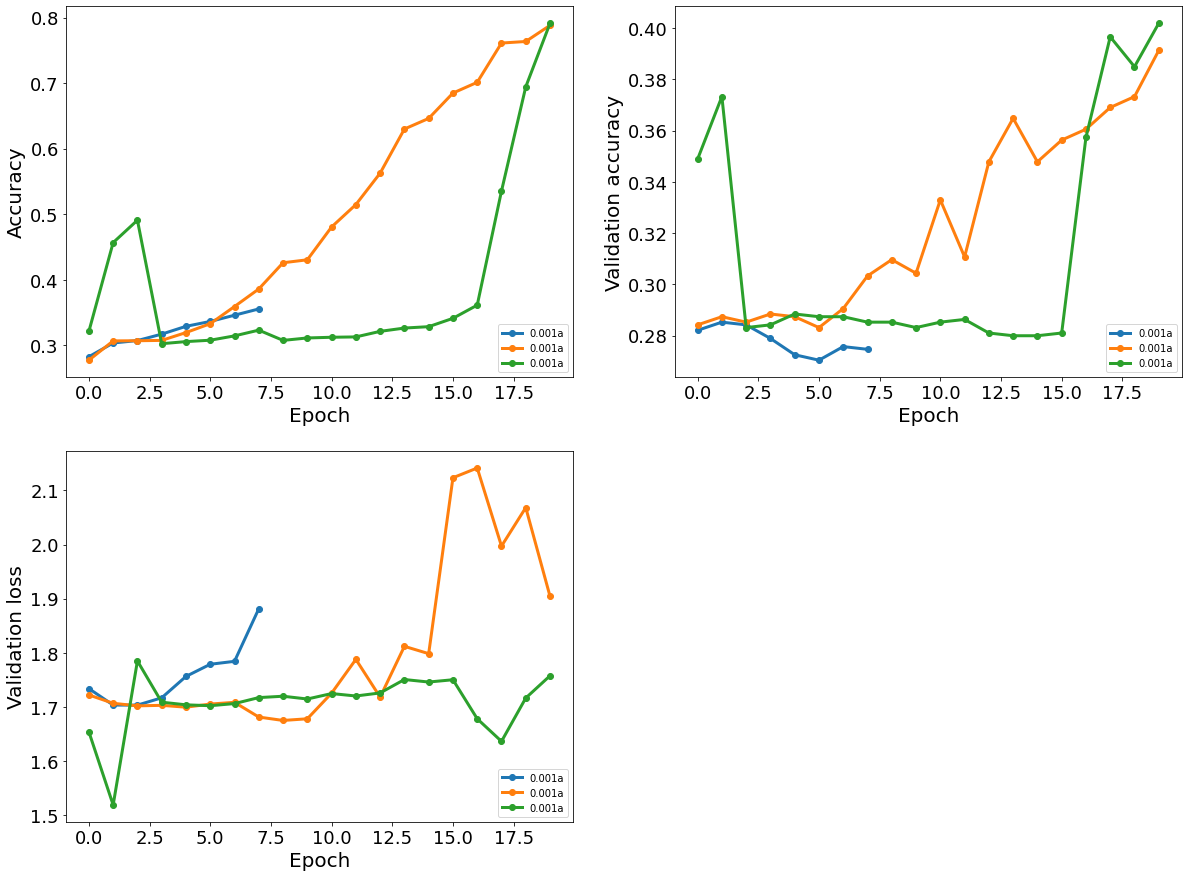

In [ ]:
#nie wiem czemu (test_, l_rs) nie działa
multi_graph(test_, [0.001, 0.001, 0.001])

Widać, że model ze zmiennym learning rate radzi sobie najlepiej. Porównajmy go z początkowym większym learning rate

test_2 -> model ze schedulerem

l_r = 0.001

In [ ]:
test2 = my_model(l_r)
test_2 = training(test2, epochs, batch_size, False, True)

In [ ]:
rates_sch = []
rates_sch.append(l_r)

models_sch = []
models_sch.append(test_2)

l_r_temp = 0.01
test3 = my_model(l_r_temp)
rates_sch.append(l_r_temp)

l_r_temp = 0.005
test4 = my_model(l_r_temp)
rates_sch.append(l_r_temp)

In [ ]:
test_3 = training(test3, epochs, batch_size, False, True)
models_sch.append(test_3)

test_4 = training(test4, epochs, batch_size, False, True)
models_sch.append(test_4)

Epoch 1/20
236/236 [==============================] - 68s 279ms/step - loss: 344.0374 - accuracy: 0.2894 - val_loss: 1.7418 - val_accuracy: 0.2641
Epoch 2/20
236/236 [==============================] - 67s 278ms/step - loss: 1.7260 - accuracy: 0.2942 - val_loss: 1.7408 - val_accuracy: 0.2641
Epoch 3/20
236/236 [==============================] - 66s 277ms/step - loss: 1.7297 - accuracy: 0.2927 - val_loss: 1.7417 - val_accuracy: 0.2641
Epoch 4/20
236/236 [==============================] - 67s 277ms/step - loss: 1.7253 - accuracy: 0.2942 - val_loss: 1.7400 - val_accuracy: 0.2641
Epoch 5/20
236/236 [==============================] - 67s 278ms/step - loss: 1.7234 - accuracy: 0.2935 - val_loss: 1.7412 - val_accuracy: 0.2641
Epoch 6/20
236/236 [==============================] - 68s 285ms/step - loss: 1.7249 - accuracy: 0.2932 - val_loss: 1.7407 - val_accuracy: 0.2641
Epoch 7/20
236/236 [==============================] - 67s 278ms/step - loss: 1.7264 - accuracy: 0.2927 - val_loss: 1.7413 - val_

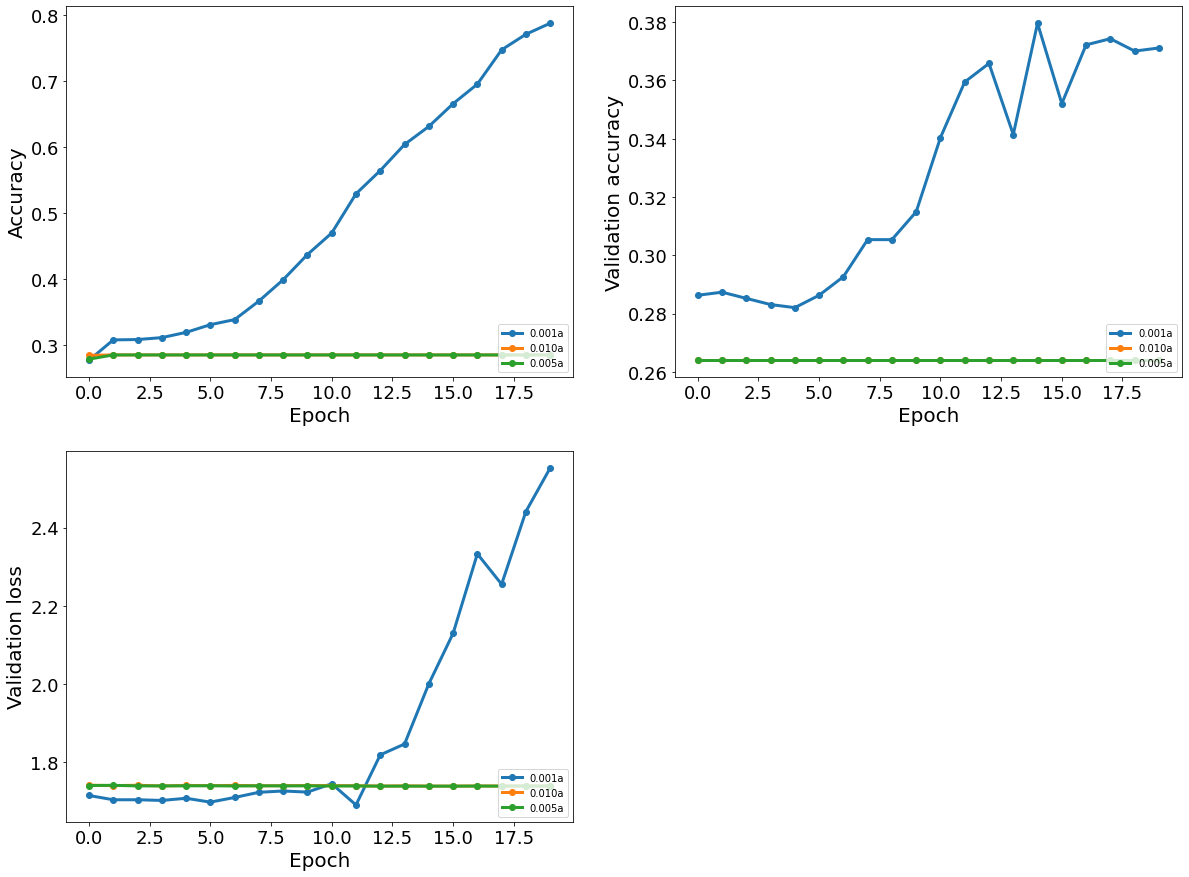

In [ ]:
multi_graph(models_sch, rates_sch)

#### Porównanie ilości epok

W ramach przypomnienia kod generujący model aktualny:

---

```
def my_model(l_r):

  model = Sequential()

  model.add(Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)))
  model.add(Conv2D(32, (3,3), activation='relu'))
  model.add(MaxPooling2D(2,2))
  model.add(Dropout(0.4))

  model.add(Conv2D(64, (3,3), activation='relu'))
  model.add(Conv2D(64, (3,3), activation='relu'))
  model.add(MaxPooling2D(2,2))
  model.add(Dropout(0.4))

  model.add(Flatten())

  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_cls, activation='softmax'))


  opt = keras.optimizers.Adam(learning_rate=l_r)

  model.compile(optimizer=opt ,loss='SparseCategoricalCrossentropy',metrics=['accuracy'])

  return model
```




---



Widać, że dla learning rate 0.001 wyniki są znacznie lepsze kosztem niewielkiej różnicy loss (bezwzględnej). Sprawdzę wyniki dla większej ilości epok.

In [ ]:
m_epochs = [20, 30, 40, 50]
l_r = 0.001
hist_ep = []
models_ep = []

In [ ]:
hist_ep = []
models_ep = []

for e in m_epochs:
  temp = my_model(l_r)
  temp_ = training(temp, e, batch_size, False, True)
  
  #--------------------
  # hist_ep - wartosci model.history
  # models_ep - cale wyuczone modele
  #--------------------
  hist_ep.append(temp_)
  models_ep.append(temp)

Epoch 1/20
236/236 [==============================] - 88s 366ms/step - loss: 115.1681 - accuracy: 0.2623 - val_loss: 1.7164 - val_accuracy: 0.2842
Epoch 2/20
236/236 [==============================] - 87s 362ms/step - loss: 1.6998 - accuracy: 0.3100 - val_loss: 1.6867 - val_accuracy: 0.3012
Epoch 3/20
236/236 [==============================] - 87s 361ms/step - loss: 1.6724 - accuracy: 0.3359 - val_loss: 1.6873 - val_accuracy: 0.3171
Epoch 4/20
236/236 [==============================] - 87s 361ms/step - loss: 1.6420 - accuracy: 0.3473 - val_loss: 1.7094 - val_accuracy: 0.2863
Epoch 5/20
236/236 [==============================] - 86s 360ms/step - loss: 1.5892 - accuracy: 0.3902 - val_loss: 1.6965 - val_accuracy: 0.3181
Epoch 6/20
236/236 [==============================] - 87s 361ms/step - loss: 1.5094 - accuracy: 0.4169 - val_loss: 1.7293 - val_accuracy: 0.3128
Epoch 7/20
236/236 [==============================] - 86s 360ms/step - loss: 1.4508 - accuracy: 0.4545 - val_loss: 1.7510 - val_

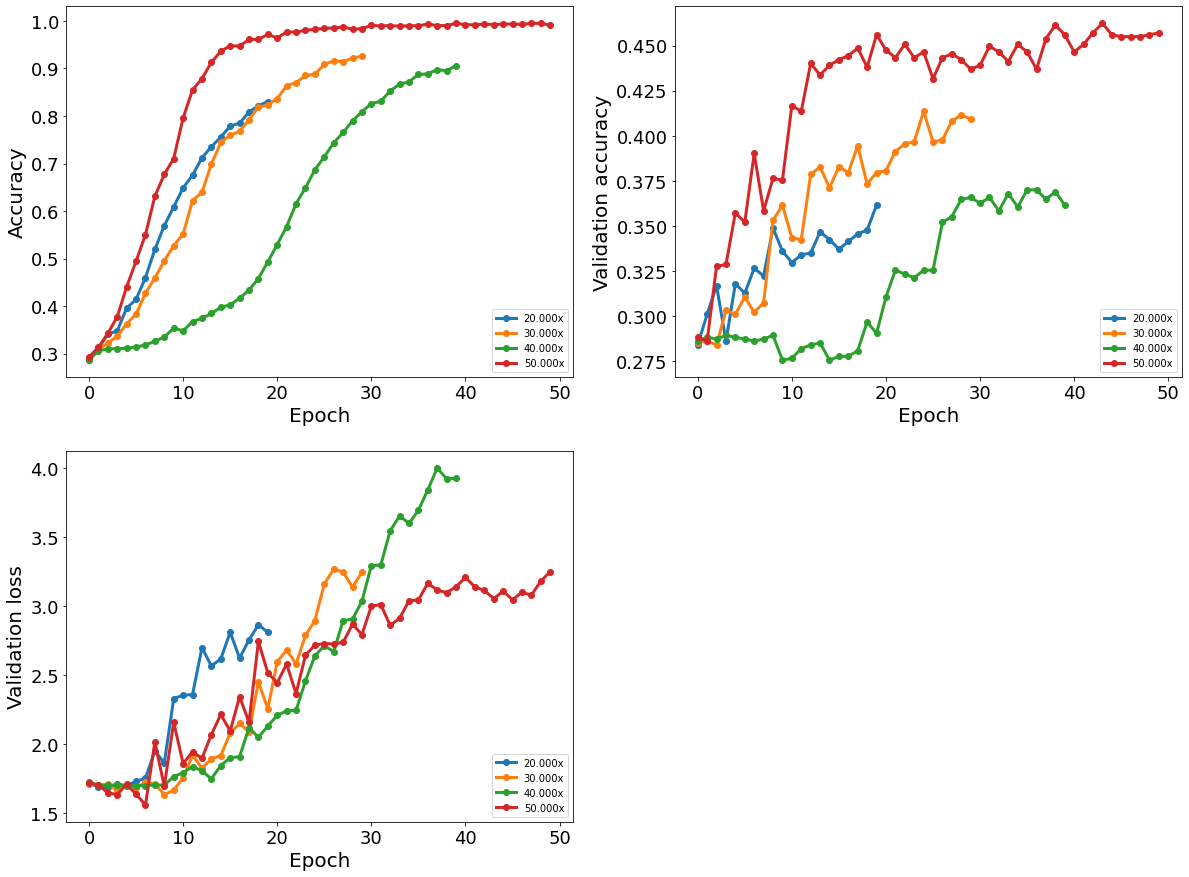

In [ ]:
multi_graph(hist_ep, m_epochs)

W celach badawczych stworzę nowy model i porównam najlepszy poprzedni z możliwymi kolejnymi jak i z ResNet50v2 bez wyuczonych wag. 

Zapisywanie histogramów w celu późniejszej wizualizacji bez ponownej nauki (każda nauka może i prawdopodobnie zwróci inne wyniki!)

In [ ]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
model_20 = pd.DataFrame(hist_ep[0].history)      
model_30 = pd.DataFrame(hist_ep[1].history)      
model_40 = pd.DataFrame(hist_ep[2].history)     
model_50 = pd.DataFrame(hist_ep[3].history) 

# save to json:  
json_20 = '/content/drive/MyDrive/models/hist/mod20e_0.001lr.json' 
json_30 = '/content/drive/MyDrive/models/hist/mod30e_0.001lr.json' 
json_40 = '/content/drive/MyDrive/models/hist/mod40e_0.001lr.json' 
json_50 = '/content/drive/MyDrive/models/hist/mod50e_0.001lr.json' 

with open(json_20, mode='w') as f:
    model_20.to_json(f)

with open(json_30, mode='w') as f:
    model_30.to_json(f)

with open(json_40, mode='w') as f:
    model_40.to_json(f)

with open(json_50, mode='w') as f:
    model_50.to_json(f)

Lub przy pomocy numpy:

In [ ]:
np.save('/content/drive/MyDrive/models/hist/mod30e_0.001lr.npy',hist_ep[1].history)
np.save('/content/drive/MyDrive/models/hist/mod40e_0.001lr.npy',hist_ep[2].history)
np.save('/content/drive/MyDrive/models/hist/mod50e_0.001lr.npy',hist_ep[3].history)

In [ ]:
#model_30 = np.load('/content/drive/MyDrive/models/hist/mod30e_0.001lr.npy',allow_pickle='TRUE').item()
#model_40 = np.load('/content/drive/MyDrive/models/hist/mod40e_0.001lr.npy',allow_pickle='TRUE').item()
#model_50 = np.load('/content/drive/MyDrive/models/hist/mod50e_0.001lr.npy',allow_pickle='TRUE').item()

Zapisanie wag:

In [ ]:
i = 0
for model in models_ep:
  model.save('/content/drive/MyDrive/models/model' + str(m_epochs[i]) +'e_' + str(l_r))
  i += 1

INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/model20e_0.001/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/model30e_0.001/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/model40e_0.001/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/model50e_0.001/assets


#### Test ResNet50v2

In [ ]:
#(w) - czy z wagami (imagenet)
def ResNet50v2(w = False, l_r = 0.001):

  model = Sequential()
  if w == False:
    model.add(tf.keras.applications.ResNet50V2(
      include_top=True,
      weights=None,
      classes=6,
      classifier_activation="softmax",
    ))

  else:
    model.add(tf.keras.applications.ResNet50V2(
        include_top=False,
        input_shape = (224, 224, 3),
        weights='imagenet'
    ))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.4))

    model.add(Dense(n_cls, activation='softmax'))

  opt = keras.optimizers.Adam(learning_rate=l_r)
  model.compile(optimizer=opt ,loss='SparseCategoricalCrossentropy',metrics=['accuracy'])

  return model

Do porównania z moim własnym modelem:

In [ ]:
m_epochs_rn = [20, 30, 40, 50]
l_r = 0.001
hist_ep_rn = []
models_ep_rn = []

In [ ]:
ROZGRZEWKOWY = ResNet50v2(True)
training(ROZGRZEWKOWY, 1, batch_size, False, True)

118/118 [==============================] - 606s 4s/step - loss: 1.9129 - accuracy: 0.3947 - val_loss: 1.8652 - val_accuracy: 0.2662


Poniższy kod jest niewykorzystany, można zastąpić nim zapisywanie modeli dla wygody.

In [ ]:
import pandas as pd
# convert the history.history dict to a pandas DataFrame:
def save_model(args, models, hist, name): 
  resnet = []
  for i in range(4):
    resnet.append(pd.DataFrame(test_hist[i].history))

  # save to json:  
  jsons = []
  for i in range(4):
    jsons.append('/content/drive/MyDrive/models/hist/mod_'+str(args[i])+'lr_'+name+'.json' )

  # saving
  for i in range(4):
    with open(jsons[i], mode='w') as f:
      resnet[i].to_json(f)

  i = 0
  for model in test_models:
    model.save('/content/drive/MyDrive/models/mod_' + str(args[i]) +'lr_'+name+'.json')
    i += 1

#save_model(rates, test_models, test_hist, 'ResNet50v2')
#save_model(rates, test_models2, test_hist2, 'ResNet50v2_tl')

NameError: ignored

In [ ]:
test_hist = []
test_models = []
rates = [0.0001, 0.0005, 0.001, 0.005]

for a in rates:
  temp = ResNet50v2(True, a)
  temp_ = training(temp, 30, batch_size, False, True)
  
  #--------------------
  # hist_ep - wartosci model.history
  # models_ep - cale wyuczone modele
  #--------------------
  test_hist.append(temp_)
  test_models.append(temp)

Epoch 1/30
118/118 [==============================] - 74s 568ms/step - loss: 2.8116 - accuracy: 0.3185 - val_loss: 1.7854 - val_accuracy: 0.2153
Epoch 2/30
118/118 [==============================] - 69s 565ms/step - loss: 1.2171 - accuracy: 0.5057 - val_loss: 1.0459 - val_accuracy: 0.5599
Epoch 3/30
118/118 [==============================] - 69s 565ms/step - loss: 1.0003 - accuracy: 0.5958 - val_loss: 0.9325 - val_accuracy: 0.5663
Epoch 4/30
118/118 [==============================] - 69s 567ms/step - loss: 0.8356 - accuracy: 0.6574 - val_loss: 0.8420 - val_accuracy: 0.6172
Epoch 5/30
118/118 [==============================] - 69s 568ms/step - loss: 0.7629 - accuracy: 0.6783 - val_loss: 0.7437 - val_accuracy: 0.6638
Epoch 6/30
118/118 [==============================] - 69s 566ms/step - loss: 0.5605 - accuracy: 0.7764 - val_loss: 0.6347 - val_accuracy: 0.7094
Epoch 7/30
118/118 [==============================] - 69s 570ms/step - loss: 0.5221 - accuracy: 0.7984 - val_loss: 0.4869 - val_ac

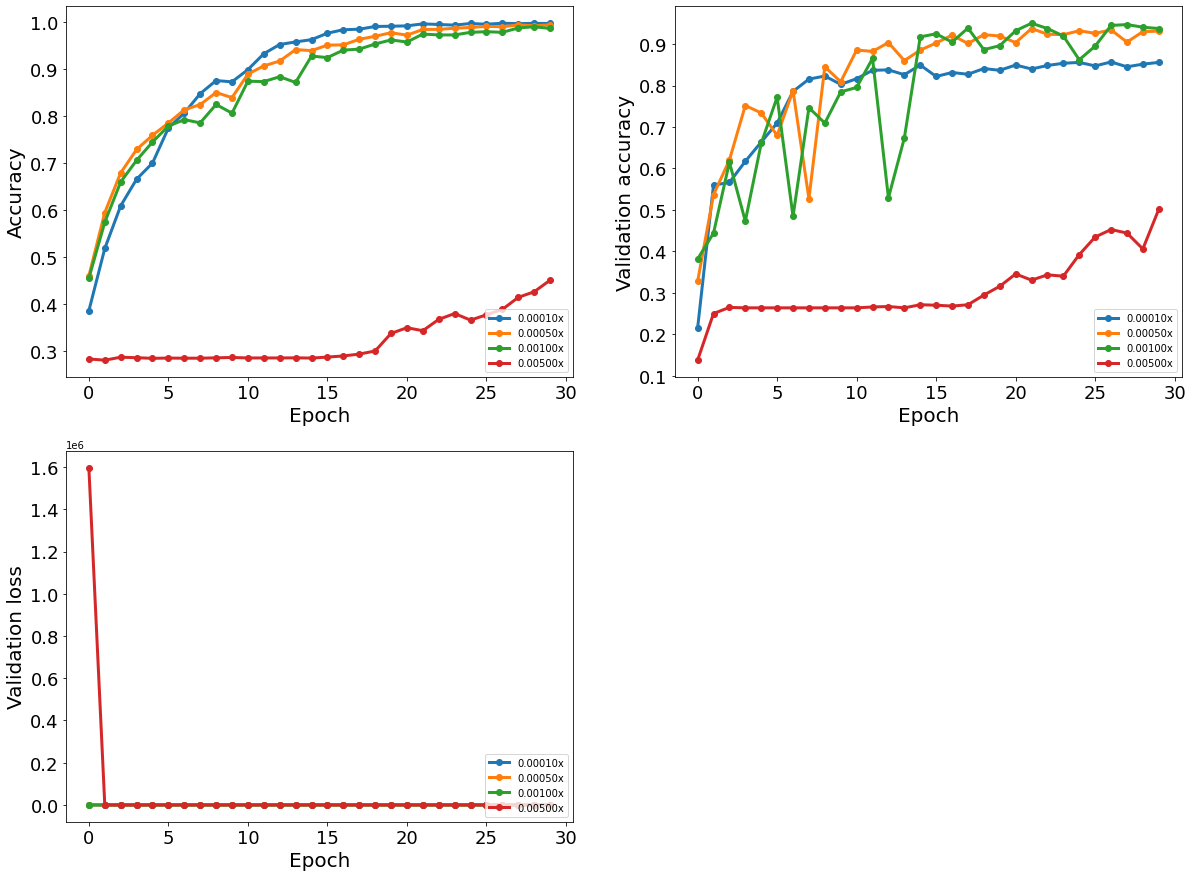

In [ ]:
multi_graph(test_hist, rates)

In [ ]:
hist_ep_rn = []
models_ep_rn = []

for e in m_epochs_rn:
  temp = ResNet50v2()
  temp_ = training(temp, e, batch_size, False, True)
  
  #--------------------
  # hist_ep - wartosci model.history
  # models_ep - cale wyuczone modele
  #--------------------
  hist_ep_rn.append(temp_)
  models_ep_rn.append(temp)

Epoch 1/20
236/236 [==============================] - 93s 372ms/step - loss: 1.4363 - accuracy: 0.4540 - val_loss: 139.2090 - val_accuracy: 0.1177
Epoch 2/20
236/236 [==============================] - 88s 366ms/step - loss: 0.8895 - accuracy: 0.6175 - val_loss: 35.3209 - val_accuracy: 0.1177
Epoch 3/20
236/236 [==============================] - 88s 367ms/step - loss: 0.7240 - accuracy: 0.6792 - val_loss: 27.3540 - val_accuracy: 0.1209
Epoch 4/20
236/236 [==============================] - 88s 367ms/step - loss: 0.6919 - accuracy: 0.7008 - val_loss: 7.0091 - val_accuracy: 0.1898
Epoch 5/20
236/236 [==============================] - 88s 368ms/step - loss: 0.5698 - accuracy: 0.7606 - val_loss: 1.3846 - val_accuracy: 0.3828
Epoch 6/20
236/236 [==============================] - 88s 368ms/step - loss: 0.5364 - accuracy: 0.7779 - val_loss: 0.7426 - val_accuracy: 0.6935
Epoch 7/20
236/236 [==============================] - 88s 367ms/step - loss: 0.4786 - accuracy: 0.8099 - val_loss: 2.2903 - va

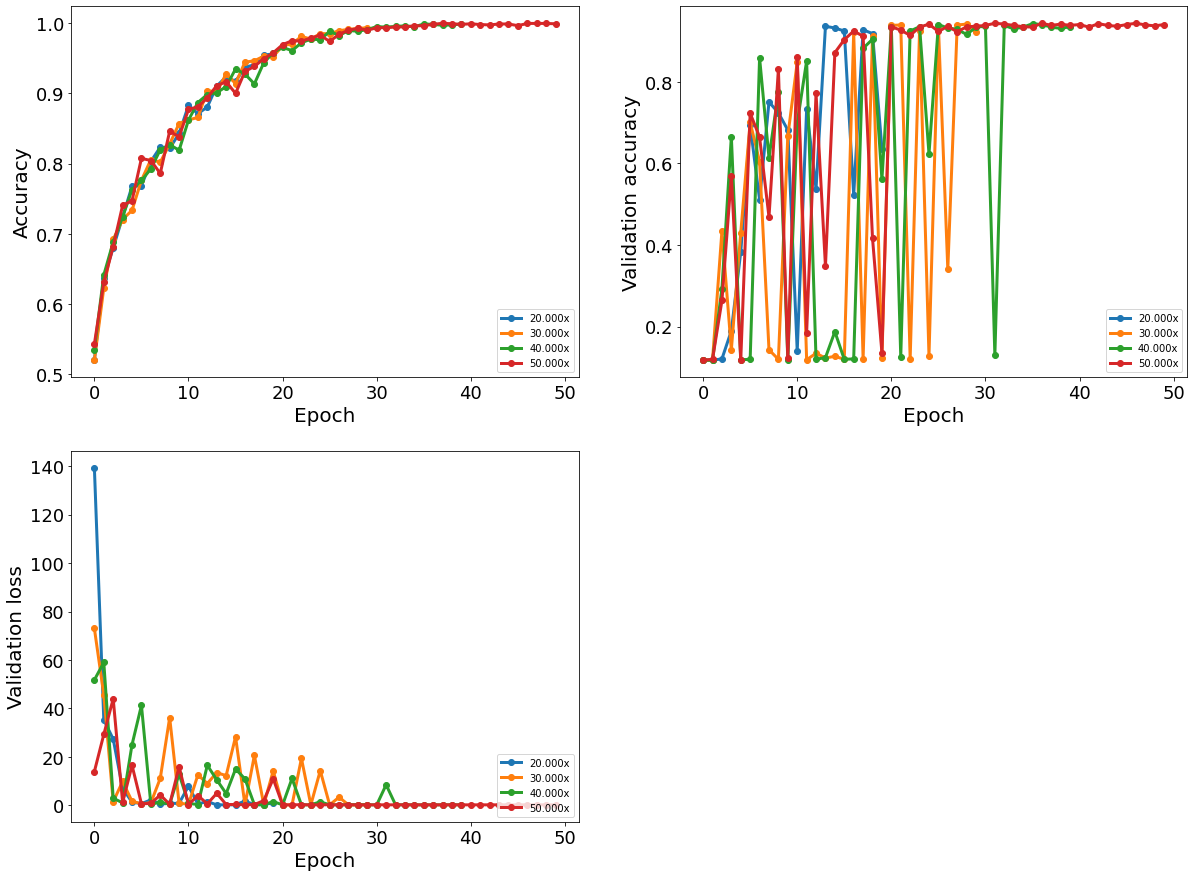

In [ ]:
multi_graph(hist_ep_rn, m_epochs_rn)

Zapisanie wag:

In [ ]:
import pandas as pd
# convert the history.history dict to a pandas DataFrame:     
model_20 = pd.DataFrame(hist_ep_rn[0].history)      
model_30 = pd.DataFrame(hist_ep_rn[1].history)      
model_40 = pd.DataFrame(hist_ep_rn[2].history)     
model_50 = pd.DataFrame(hist_ep_rn[3].history) 

# save to json:  
json_20 = '/content/drive/MyDrive/models/hist/mod20e_Res50v2.json' 
json_30 = '/content/drive/MyDrive/models/hist/mod30e_Res50v2.json' 
json_40 = '/content/drive/MyDrive/models/hist/mod40e_Res50v2.json' 
json_50 = '/content/drive/MyDrive/models/hist/mod50e_Res50v2.json' 

with open(json_20, mode='w') as f:
    model_20.to_json(f)

with open(json_30, mode='w') as f:
    model_30.to_json(f)

with open(json_40, mode='w') as f:
    model_40.to_json(f)

with open(json_50, mode='w') as f:
    model_50.to_json(f)

In [ ]:
i = 0
for model in models_ep_rn:
  model.save('/content/drive/MyDrive/models/model' + str(m_epochs_rn[i]) +'e_' + 'ResNet50v2')
  i += 1

INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/model20e_ResNet50v2/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/model30e_ResNet50v2/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/model40e_ResNet50v2/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/model50e_ResNet50v2/assets


ResNet50v2 Transfer learning:

In [ ]:
hist_ep_rn_t = []
models_ep_rn_t = []

for e in m_epochs_rn:
  temp = ResNet50v2(True)
  temp_ = training(temp, e, batch_size, False, True)
  
  #--------------------
  # hist_ep - wartosci model.history
  # models_ep - cale wyuczone modele
  #--------------------
  hist_ep_rn_t.append(temp_)
  models_ep_rn_t.append(temp)

Epoch 1/20
236/236 [==============================] - 92s 365ms/step - loss: 2.1628 - accuracy: 0.3035 - val_loss: 1.1431 - val_accuracy: 0.4793
Epoch 2/20
236/236 [==============================] - 87s 364ms/step - loss: 1.1498 - accuracy: 0.5094 - val_loss: 0.8291 - val_accuracy: 0.6501
Epoch 3/20
236/236 [==============================] - 87s 364ms/step - loss: 0.8920 - accuracy: 0.6141 - val_loss: 0.8071 - val_accuracy: 0.6522
Epoch 4/20
236/236 [==============================] - 88s 367ms/step - loss: 0.7767 - accuracy: 0.6486 - val_loss: 0.8043 - val_accuracy: 0.6564
Epoch 5/20
236/236 [==============================] - 88s 368ms/step - loss: 0.7003 - accuracy: 0.6857 - val_loss: 0.6100 - val_accuracy: 0.7179
Epoch 6/20
236/236 [==============================] - 88s 367ms/step - loss: 0.6641 - accuracy: 0.7206 - val_loss: 0.4904 - val_accuracy: 0.7794
Epoch 7/20
236/236 [==============================] - 88s 368ms/step - loss: 0.6036 - accuracy: 0.7504 - val_loss: 1.0953 - val_ac

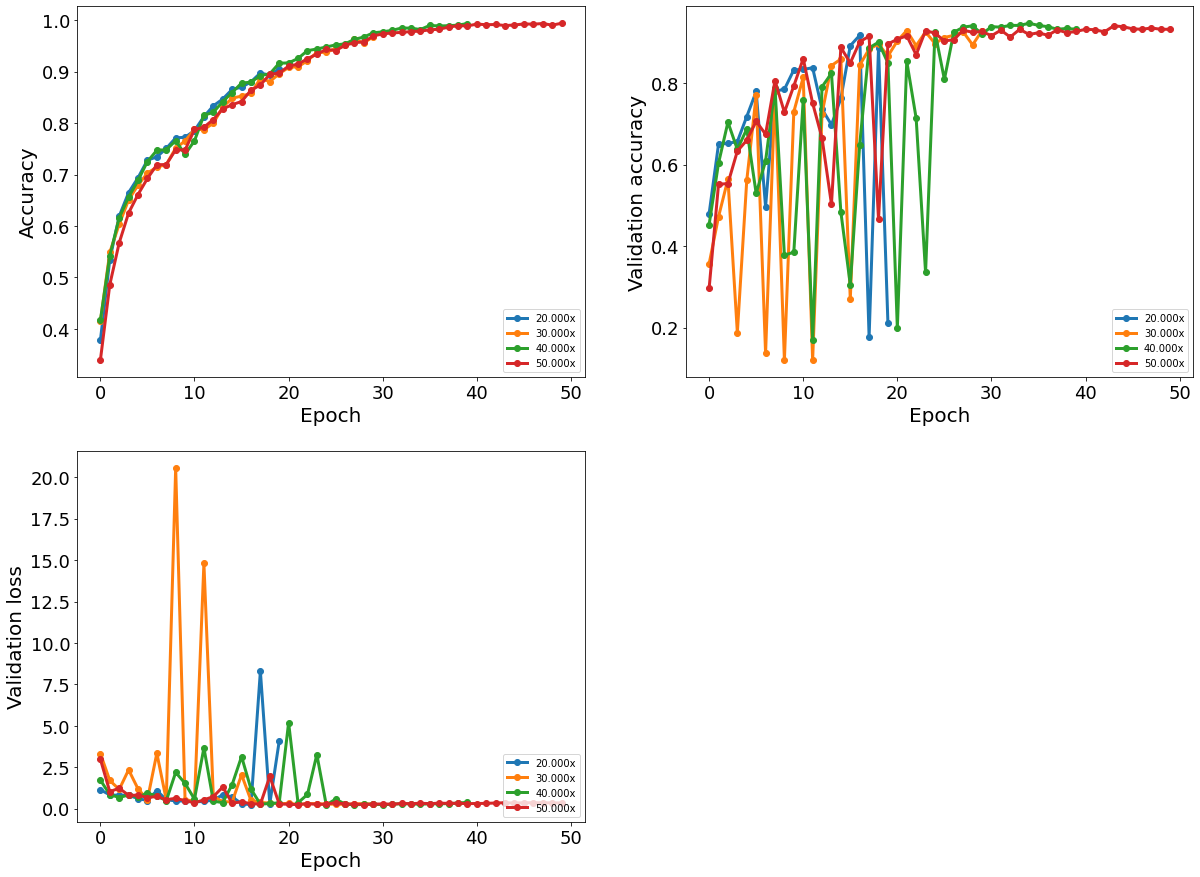

In [ ]:
multi_graph(hist_ep_rn_t, m_epochs_rn)

In [ ]:
import pandas as pd
# convert the history.history dict to a pandas DataFrame:     
model_20 = pd.DataFrame(hist_ep_rn_t[0].history)      
model_30 = pd.DataFrame(hist_ep_rn_t[1].history)      
model_40 = pd.DataFrame(hist_ep_rn_t[2].history)     
model_50 = pd.DataFrame(hist_ep_rn_t[3].history) 

# save to json:  
json_20 = '/content/drive/MyDrive/models/hist/mod20e_Res50v2_t.json' 
json_30 = '/content/drive/MyDrive/models/hist/mod30e_Res50v2_t.json' 
json_40 = '/content/drive/MyDrive/models/hist/mod40e_Res50v2_t.json' 
json_50 = '/content/drive/MyDrive/models/hist/mod50e_Res50v2_t.json' 

with open(json_20, mode='w') as f:
    model_20.to_json(f)

with open(json_30, mode='w') as f:
    model_30.to_json(f)

with open(json_40, mode='w') as f:
    model_40.to_json(f)

with open(json_50, mode='w') as f:
    model_50.to_json(f)

In [ ]:
i = 0
for model in models_ep_rn_t:
  model.save('/content/drive/MyDrive/models/model' + str(m_epochs_rn[i]) +'e_' + 'ResNet50v2_t')
  i += 1

INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/model20e_ResNet50v2_t/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/model30e_ResNet50v2_t/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/model40e_ResNet50v2_t/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/model50e_ResNet50v2_t/assets


# Macierze konfuzji

## Wczytanie modeli

In [ ]:
import os, glob

LOADED_MODELS = []
LOADED_NAMES = []


In [ ]:
for filename in glob.glob("/content/drive/MyDrive/models/model*"):
  print(filename[30:])

model20e_0.001
model30e_0.001
model40e_0.001
model50e_0.001
model20e_ResNet50v2
model30e_ResNet50v2
model40e_ResNet50v2
model50e_ResNet50v2
model20e_ResNet50v2_t
model30e_ResNet50v2_t
model40e_ResNet50v2_t
model50e_ResNet50v2_t


In [ ]:
# SPRAWDZANIE KAŻDEJ NAZWY ODPOWIADAJĄCEJ ZAPISANYM
for filename in glob.glob("/content/drive/MyDrive/models/model*"):
  temp = keras.models.load_model(filename)
  LOADED_MODELS.append(temp)
  print(filename[30:] + ' - model loaded!')
  LOADED_NAMES.append(filename[30:])
  

model20e_0.001 - model loaded!
model30e_0.001 - model loaded!
model40e_0.001 - model loaded!
model50e_0.001 - model loaded!
model20e_ResNet50v2 - model loaded!
model30e_ResNet50v2 - model loaded!
model40e_ResNet50v2 - model loaded!
model50e_ResNet50v2 - model loaded!
model20e_ResNet50v2_t - model loaded!
model30e_ResNet50v2_t - model loaded!
model40e_ResNet50v2_t - model loaded!
model50e_ResNet50v2_t - model loaded!


In [ ]:
y = np.concatenate([y for x, y in val_ds], axis=0)

In [ ]:
i=0
for images, label in val_ds.as_numpy_iterator():
  i+=1
  print('Iteracja '+ str(i))
  print(label)

Z wywyższego kodu wychodzi sama zasada działania BatchDataset. Wszystkie dane są w 32-elementowych batchach. Kod poprawnie generujący klasy będzie wyglądał więc tak:

In [ ]:
y_true = []
for images, label in val_ds.as_numpy_iterator():
  y_true.extend(label)
print(y_true)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix

Y_pred = LOADED_MODELS[11].predict(val_ds)
y_pred = np.argmax(Y_pred, axis=1)
print(confusion_matrix(y_true, y_pred))
print(multilabel_confusion_matrix(y_true, y_pred))

[[64 57 28 38 39 23]
 [54 38 27 28 36 31]
 [28 25 12 13 21 13]
 [42 34 14 14 17  9]
 [35 36 13 14 17 12]
 [28 25 17 15 10 16]]
[[[507 187]
  [185  64]]

 [[552 177]
  [176  38]]

 [[732  99]
  [100  12]]

 [[705 108]
  [116  14]]

 [[693 123]
  [110  17]]

 [[744  88]
  [ 95  16]]]


In [ ]:
classes = val_ds.class_names

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix
import seaborn as sns

def drawConf(model, name):
  Y_pred = model.predict(val_ds)
  y_pred = np.argmax(Y_pred, axis=1)
  print('Confusion Matrix')

  cm = confusion_matrix(y_true, y_pred)
  clr = classification_report(y, y_pred)

  plt.figure(figsize=(10, 10))
  sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
  plt.xticks(ticks=np.arange(len(classes)) + 0.5, labels=classes, rotation=90)
  plt.yticks(ticks=np.arange(len(classes)) + 0.5, labels=classes, rotation=0)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix for "+ name)
  plt.show()

  plt.savefig('/content/drive/MyDrive/conf_matr/'+name+'.png')

  print("Classification Report:\n----------------------\n", clr)

  f = open("/content/drive/MyDrive/reports/"+name+'.txt', "w")
  f.write(clr)
  f.close

  print('*'*100)

Confusion Matrix


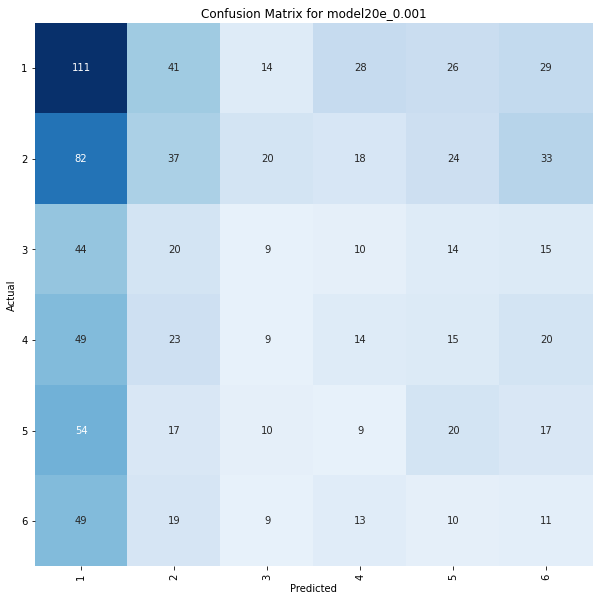

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.28      0.44      0.34       249
           1       0.20      0.15      0.17       214
           2       0.08      0.05      0.07       112
           3       0.13      0.09      0.11       130
           4       0.13      0.11      0.12       127
           5       0.11      0.13      0.12       111

    accuracy                           0.20       943
   macro avg       0.16      0.16      0.15       943
weighted avg       0.18      0.20      0.18       943

****************************************************************************************************
Confusion Matrix


<Figure size 432x288 with 0 Axes>

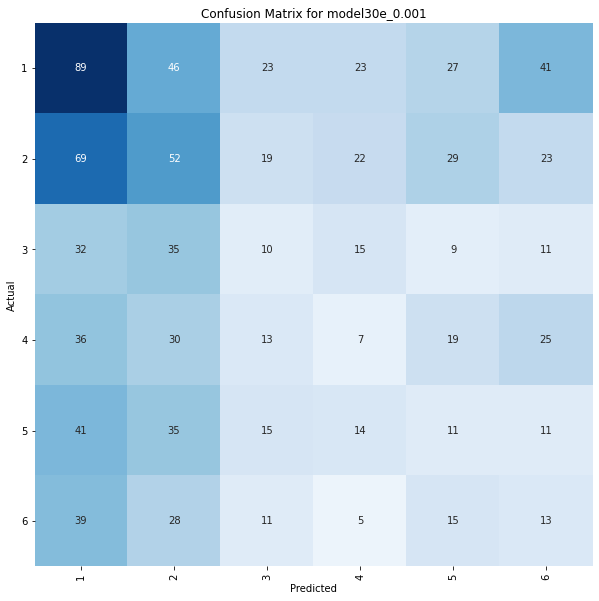

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.26      0.32      0.28       249
           1       0.19      0.20      0.19       214
           2       0.14      0.12      0.13       112
           3       0.15      0.10      0.12       130
           4       0.13      0.11      0.12       127
           5       0.10      0.12      0.11       111

    accuracy                           0.18       943
   macro avg       0.16      0.16      0.16       943
weighted avg       0.18      0.18      0.18       943

****************************************************************************************************
Confusion Matrix


<Figure size 432x288 with 0 Axes>

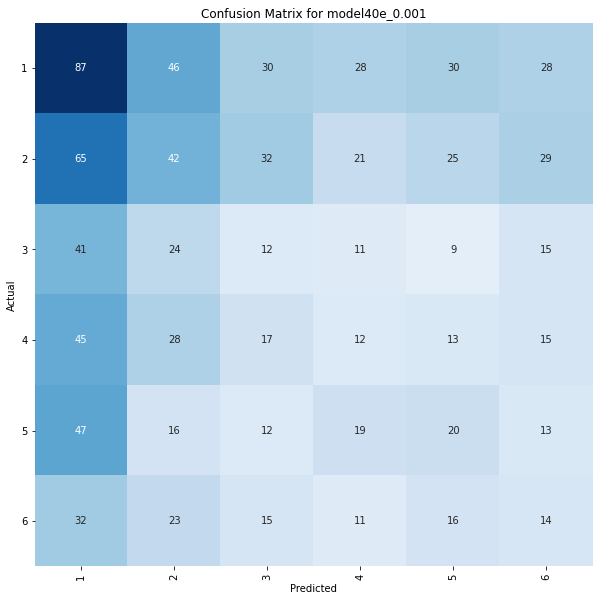

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.28      0.36      0.31       249
           1       0.23      0.19      0.21       214
           2       0.12      0.12      0.12       112
           3       0.17      0.13      0.15       130
           4       0.12      0.10      0.11       127
           5       0.14      0.14      0.14       111

    accuracy                           0.20       943
   macro avg       0.18      0.18      0.17       943
weighted avg       0.20      0.20      0.20       943

****************************************************************************************************
Confusion Matrix


<Figure size 432x288 with 0 Axes>

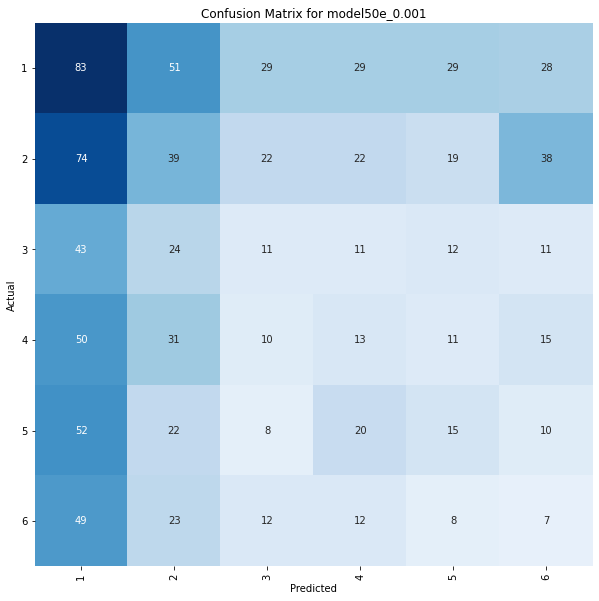

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.24      0.33      0.28       249
           1       0.26      0.23      0.25       214
           2       0.08      0.06      0.07       112
           3       0.12      0.10      0.11       130
           4       0.07      0.06      0.06       127
           5       0.16      0.15      0.15       111

    accuracy                           0.19       943
   macro avg       0.15      0.16      0.15       943
weighted avg       0.18      0.19      0.18       943

****************************************************************************************************
Confusion Matrix


<Figure size 432x288 with 0 Axes>

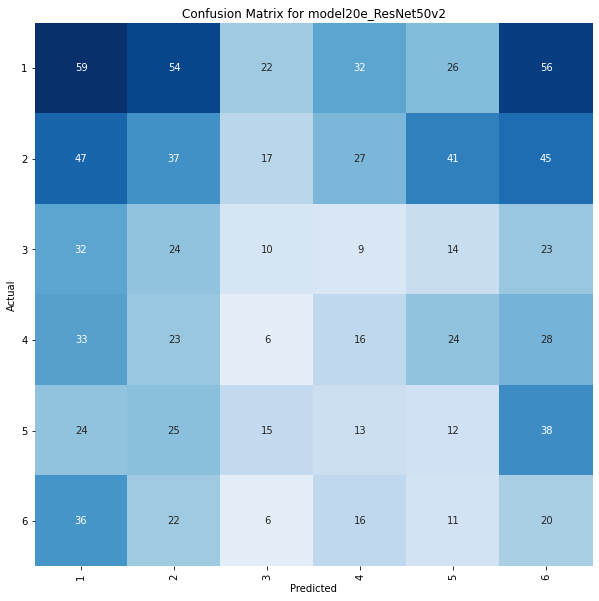

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.26      0.24      0.25       249
           1       0.25      0.21      0.23       214
           2       0.13      0.09      0.11       112
           3       0.15      0.13      0.14       130
           4       0.12      0.12      0.12       127
           5       0.12      0.23      0.16       111

    accuracy                           0.18       943
   macro avg       0.17      0.17      0.17       943
weighted avg       0.19      0.18      0.18       943

****************************************************************************************************
Confusion Matrix


<Figure size 432x288 with 0 Axes>

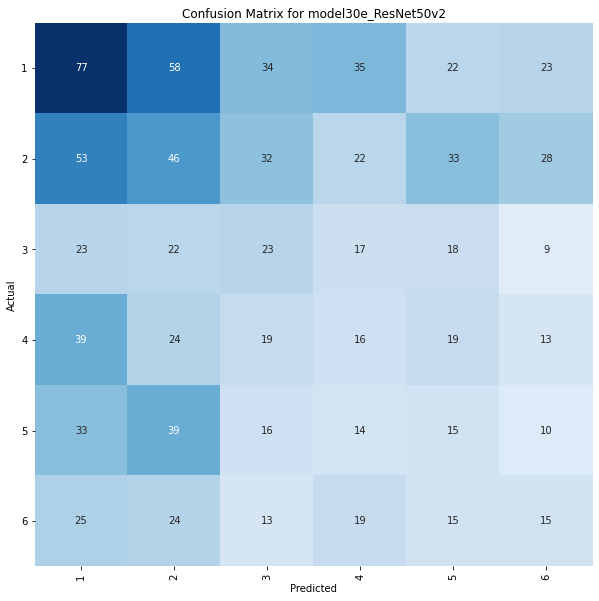

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.25      0.25      0.25       249
           1       0.22      0.22      0.22       214
           2       0.14      0.17      0.15       112
           3       0.14      0.13      0.13       130
           4       0.11      0.10      0.10       127
           5       0.15      0.14      0.14       111

    accuracy                           0.18       943
   macro avg       0.17      0.17      0.17       943
weighted avg       0.18      0.18      0.18       943

****************************************************************************************************
Confusion Matrix


<Figure size 432x288 with 0 Axes>

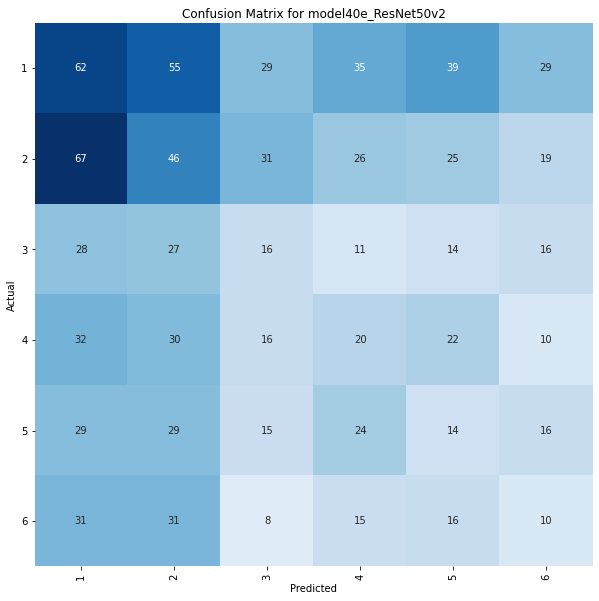

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.27      0.27      0.27       249
           1       0.17      0.17      0.17       214
           2       0.15      0.15      0.15       112
           3       0.15      0.15      0.15       130
           4       0.08      0.09      0.09       127
           5       0.11      0.10      0.10       111

    accuracy                           0.17       943
   macro avg       0.15      0.15      0.15       943
weighted avg       0.17      0.17      0.17       943

****************************************************************************************************
Confusion Matrix


<Figure size 432x288 with 0 Axes>

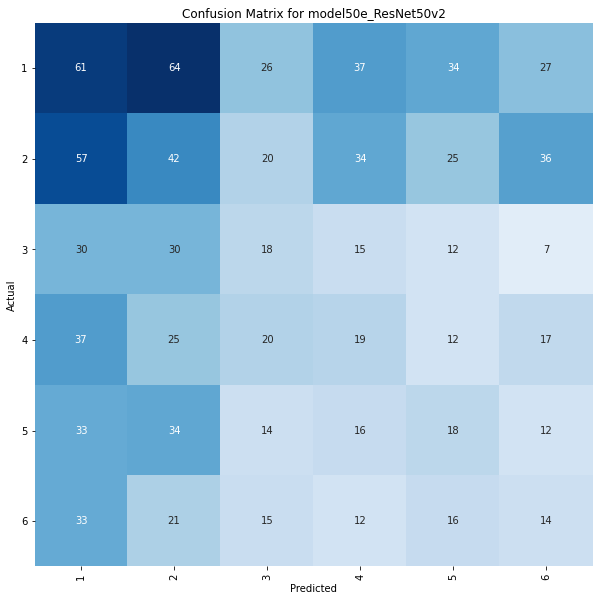

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.29      0.29      0.29       249
           1       0.23      0.23      0.23       214
           2       0.09      0.09      0.09       112
           3       0.15      0.15      0.15       130
           4       0.17      0.16      0.16       127
           5       0.13      0.14      0.13       111

    accuracy                           0.20       943
   macro avg       0.18      0.18      0.18       943
weighted avg       0.20      0.20      0.20       943

****************************************************************************************************
Confusion Matrix


<Figure size 432x288 with 0 Axes>

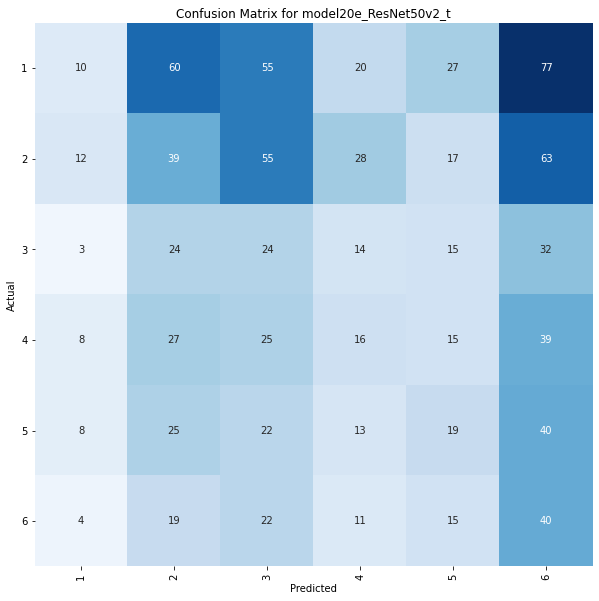

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.31      0.06      0.10       249
           1       0.28      0.25      0.26       214
           2       0.12      0.21      0.15       112
           3       0.16      0.12      0.14       130
           4       0.19      0.16      0.17       127
           5       0.14      0.36      0.20       111

    accuracy                           0.18       943
   macro avg       0.20      0.19      0.17       943
weighted avg       0.22      0.18      0.17       943

****************************************************************************************************
Confusion Matrix


<Figure size 432x288 with 0 Axes>

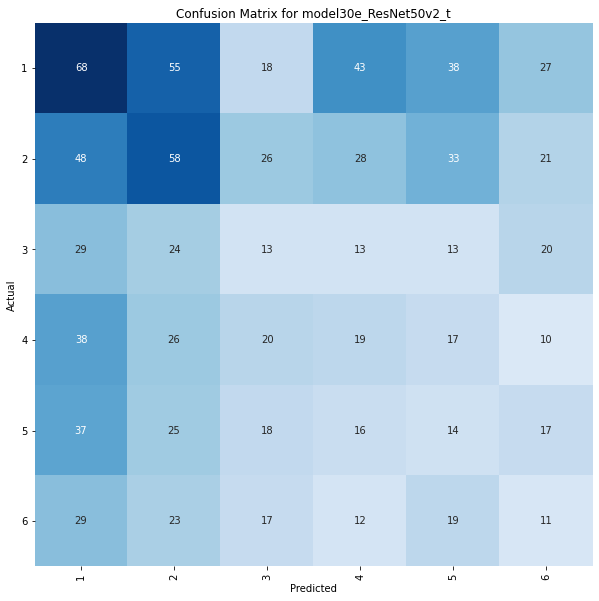

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.27      0.27      0.27       249
           1       0.21      0.21      0.21       214
           2       0.12      0.12      0.12       112
           3       0.15      0.15      0.15       130
           4       0.13      0.14      0.14       127
           5       0.07      0.06      0.06       111

    accuracy                           0.18       943
   macro avg       0.16      0.16      0.16       943
weighted avg       0.18      0.18      0.18       943

****************************************************************************************************
Confusion Matrix


<Figure size 432x288 with 0 Axes>

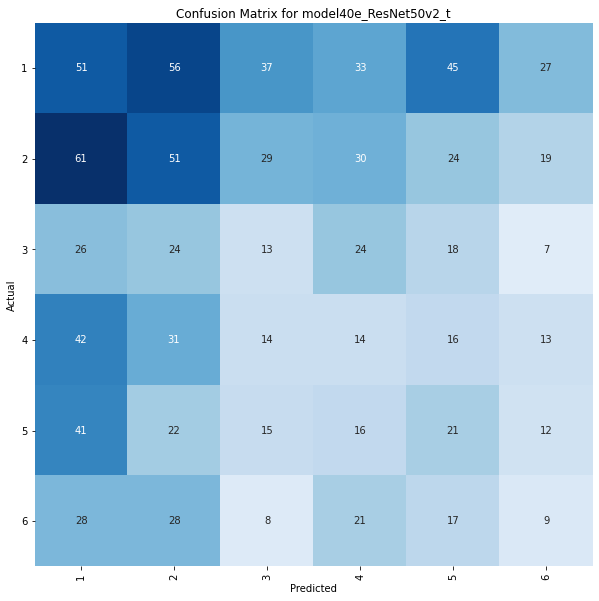

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.28      0.28      0.28       249
           1       0.18      0.18      0.18       214
           2       0.16      0.16      0.16       112
           3       0.15      0.16      0.16       130
           4       0.20      0.22      0.21       127
           5       0.10      0.08      0.09       111

    accuracy                           0.20       943
   macro avg       0.18      0.18      0.18       943
weighted avg       0.19      0.20      0.19       943

****************************************************************************************************
Confusion Matrix


<Figure size 432x288 with 0 Axes>

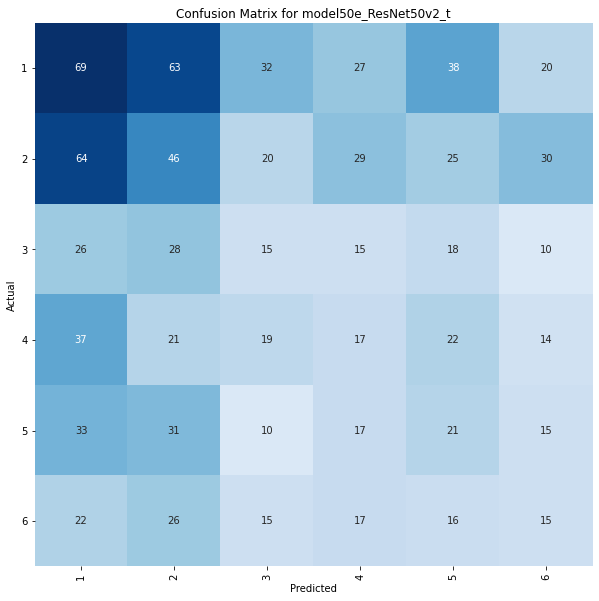

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.26      0.26      0.26       249
           1       0.23      0.23      0.23       214
           2       0.15      0.15      0.15       112
           3       0.13      0.12      0.13       130
           4       0.14      0.16      0.15       127
           5       0.13      0.13      0.13       111

    accuracy                           0.19       943
   macro avg       0.17      0.17      0.17       943
weighted avg       0.19      0.19      0.19       943

****************************************************************************************************


<Figure size 432x288 with 0 Axes>

In [ ]:
i = 0
for model in LOADED_MODELS:
  drawConf(model, LOADED_NAMES[i])
  i += 1

In [ ]:
# w celu sprawdzenia klas:
a = y.tolist()
print(a.count(0)) #klasa 1
print(a.count(1)) #klasa 2
print(a.count(2)) #klasa 3
print(a.count(3)) #klasa 4
print(a.count(4)) #klasa 5
print(a.count(5)) #klasa 6

249
214
112
130
127
111
0


In [ ]:
def load_img(path):
  test_image = tf.keras.preprocessing.image.load_img(
    path, grayscale=False, color_mode="rgb", target_size=(224, 224), interpolation="nearest"
  )
  img_array = keras.preprocessing.image.img_to_array(test_image)
  img_array_b = tf.expand_dims(img_array, 0)  # Create batch axis
  return img_array, img_array_b

#Wczytywanie obrazków testowych:

In [ ]:
img = []
img_paths = ['/content/drive/MyDrive/testing/4_dogs.jpg', '/content/drive/MyDrive/testing/dogs.jpg', '/content/drive/MyDrive/dataset/3/aug_0_1121.png', '/content/drive/MyDrive/dataset/3/ran_14.png', '/content/drive/MyDrive/dataset/4/aug_0_2194.png', '/content/drive/MyDrive/dataset/4/ran_193.png']
images = []

for path in img_paths:
  img_temp, img_temp_b = load_img(path)
  img.append(img_temp_b)
  images.append(img_temp)

Image nr: 1



Model model20e_0.001
1 object: 0.05, 2 objects: 0.41, 3 objects: 0.96, 4 objects: 32.27, 5 objects: 50.24, 6 objects: 16.08, 
**************************************************
Model model30e_0.001
1 object: 0.00, 2 objects: 0.08, 3 objects: 16.56, 4 objects: 83.17, 5 objects: 0.02, 6 objects: 0.17, 
**************************************************
Model model40e_0.001
1 object: 6.35, 2 objects: 0.21, 3 objects: 1.47, 4 objects: 21.39, 5 objects: 2.51, 6 objects: 68.07, 
**************************************************
Model model50e_0.001
1 object: 0.03, 2 objects: 0.28, 3 objects: 8.69, 4 objects: 15.32, 5 objects: 41.07, 6 objects: 34.61, 
**************************************************
Model model20e_ResNet50v2
1 object: 0.00, 2 objects: 0.00, 3 objects: 0.00, 4 objects: 0.00, 5 objects: 0.00, 6 objects: 100.00, 
**************************************************
Model model30e_ResNet50v2
1 object: 0.00, 2 objects: 0.00, 3 objects: 0.00, 4 objects: 0.00, 5 obj

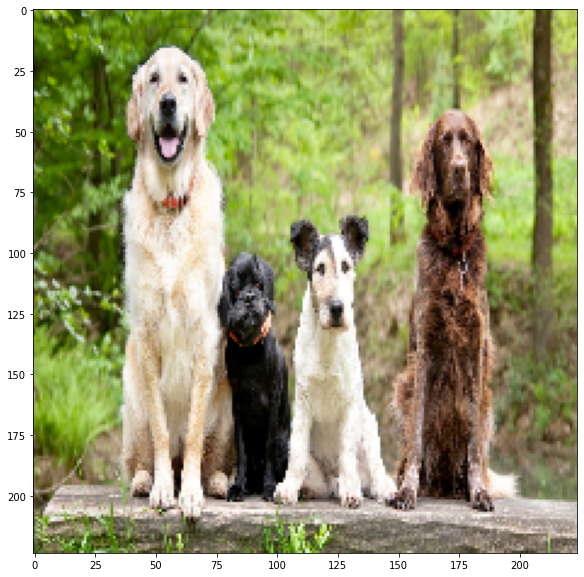

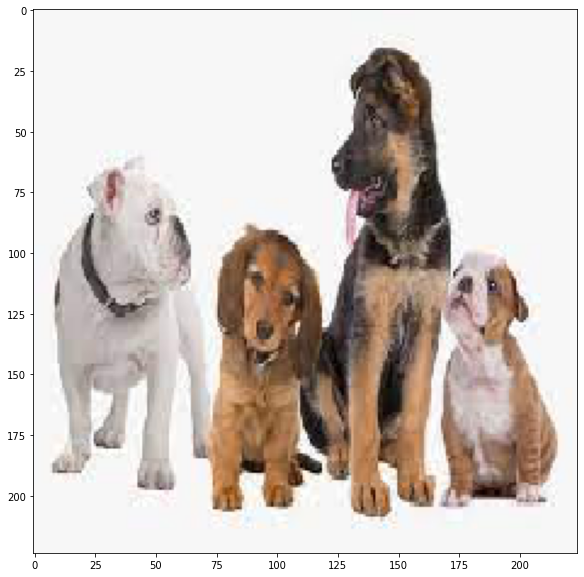

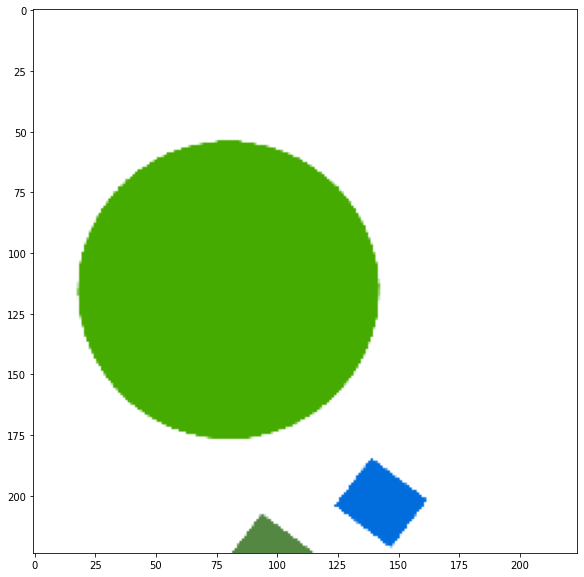

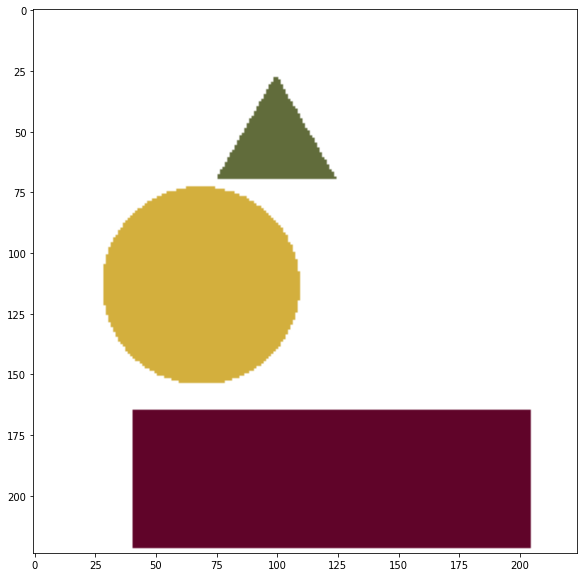

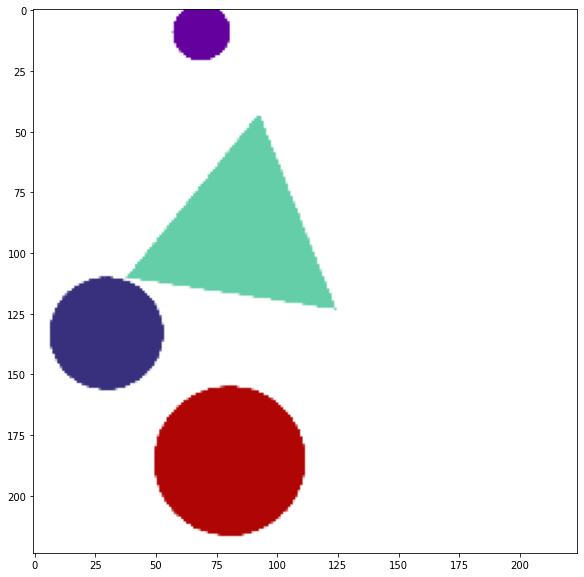

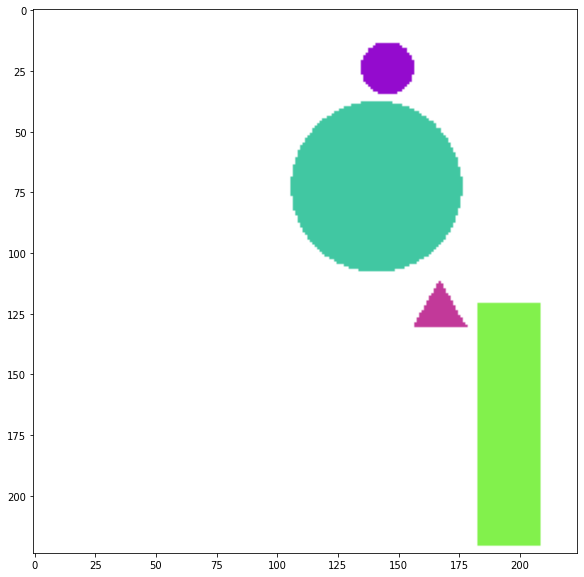

In [ ]:
j = 0
import csv

for image in img:
  print('Image nr: '+str(j+1))
  print('\n\n')
  plt.figure(figsize=(10, 10))
  plt.imshow(images[j].astype("uint8"))
  j += 1
  i = 0

  
  with open('/content/drive/MyDrive/preds/data_'+str(j)+'.csv', mode='w') as f:
    writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    for model in LOADED_MODELS:
      pred = model.predict(image)
      print('Model ' + LOADED_NAMES[i])
      print('1 object: %.2f, 2 objects: %.2f, 3 objects: %.2f, 4 objects: %.2f, 5 objects: %.2f, 6 objects: %.2f, ' %(100 * pred[0][0], 100 * pred[0][1], 100 * pred[0][2], 100 * pred[0][3], 100 * pred[0][4], 100 * pred[0][5]))
      #NAZWA MODELU, 1 OBIEKT, 2 OBIEKTY, 3 OBIEKTY, 4 OBIEKTY, 5 OBIEKTÓW, 6 OBIEKTOW
      writer.writerow([LOADED_NAMES[i], 100 * pred[0][0], 100 * pred[0][1], 100 * pred[0][2], 100 * pred[0][3], 100 * pred[0][4], 100 * pred[0][5]])
      i+=1
      print('*'*50)
  print('\n\n\n\n')